In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import random
import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt
from torchsummary import summary

from resnet import ResNet18  # Import baseline ResNet-18 model

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
from torch.optim.lr_scheduler import OneCycleLR

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True


# Custom MixUp function
def mixup(data, targets, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = data.size()[0]
    index = torch.randperm(batch_size).to(data.device)

    mixed_data = lam * data + (1 - lam) * data[index, :]
    targets_a, targets_b = targets, targets[index]
    
    return mixed_data, targets_a, targets_b, lam

# Custom CutMix function
def cutmix(data, targets, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = data.size()[0]
    index = torch.randperm(batch_size).to(data.device)

    W, H = data.size()[2], data.size()[3]
    cx, cy = np.random.randint(W), np.random.randint(H)
    cut_w, cut_h = int(W * np.sqrt(1 - lam)), int(H * np.sqrt(1 - lam))

    x1, x2 = np.clip(cx - cut_w // 2, 0, W), np.clip(cx + cut_w // 2, 0, W)
    y1, y2 = np.clip(cy - cut_h // 2, 0, H), np.clip(cy + cut_h // 2, 0, H)

    data_copy = data.clone()
    data_copy[:, :, x1:x2, y1:y2] = data[index, :, x1:x2, y1:y2]

    # Calculate actual lambda based on area ratio
    actual_lam = 1 - ((x2 - x1) * (y2 - y1)) / (W * H)
    targets_a, targets_b = targets, targets[index]
    
    return data_copy, targets_a, targets_b, actual_lam

# Transform_train pipeline
transform_train = transforms.Compose([
    transforms.AutoAugment(transforms.autoaugment.AutoAugmentPolicy.CIFAR10),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Transform Pipeline for Test Data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # Normalization
])

# Create validation split
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training set into train and validation
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Create a validation set with test transforms
valset_test_transform = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_test)
val_indices = list(range(train_size, len(trainset) + val_size))
valset = torch.utils.data.Subset(valset_test_transform, val_indices)

# Increase batch size
batch_size = 256

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


# Initialize model with Kaiming initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

print('==> Building ResNet-18 Baseline Model..')
net = ResNet18().to(device)
net.apply(init_weights)  # Apply Kaiming initialization
summary(net, (3, 32, 32)) #Display parameter count

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

# Use Label Smoothing Loss for better generalization
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Higher learning rate with OneCycleLR
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Increase training duration
num_epochs = 100
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.3, 
    steps_per_epoch=len(trainloader), 
    epochs=num_epochs,
    div_factor=10,  # Initial LR = max_lr/10
    final_div_factor=100,  # Final LR = max_lr/1000
)

==> Building ResNet-18 Baseline Model..
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728

In [3]:
def train(epoch, use_mixup=True, use_cutmix=True):
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        # Apply MixUp or CutMix probabilistically
        mixed_inputs = None
        targets_a = None
        targets_b = None
        lam = 1.0
        
        use_mixing = False
        
        if use_mixup and random.random() > 0.5:
            mixed_inputs, targets_a, targets_b, lam = mixup(inputs, targets)
            use_mixing = True
        elif use_cutmix and random.random() > 0.5:
            mixed_inputs, targets_a, targets_b, lam = cutmix(inputs, targets)
            use_mixing = True
        
        if use_mixing:
            outputs = net(mixed_inputs)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            
            # For accuracy calculation with mixed examples
            _, predicted = outputs.max(1)
            total += targets.size(0)
            
            # Calculate accuracy considering both target sets
            correct_a = predicted.eq(targets_a).float()
            correct_b = predicted.eq(targets_b).float()
            correct += (lam * correct_a + (1 - lam) * correct_b).sum().item()
        else:
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            
            # Standard accuracy calculation
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        
    print(f'Train Epoch {epoch}: Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}%')
    return train_loss / (batch_idx+1), 100.*correct/total

# Separate validation function
def validate(epoch):
    net.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    acc = 100.*correct/total
    print(f'Val Epoch {epoch}: Loss: {val_loss/(batch_idx+1):.3f} | Acc: {acc:.3f}%')
    return val_loss / (batch_idx+1), acc

def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    acc = 100.*correct/total
    print(f'Test Epoch {epoch}: Loss: {test_loss/(batch_idx+1):.3f} | Acc: {acc:.3f}%')
    return test_loss / (batch_idx+1), acc

In [4]:
# Training Loop with Logging
train_losses, val_losses, test_losses = [], [], []
train_accs, val_accs, test_accs = [], [], []

# Early stopping parameters
best_val_acc = 0
patience = 10
patience_counter = 0
best_model_path = "best_resnet18_cifar10.pth"

for epoch in range(num_epochs):
    train_loss, train_acc = train(epoch)
    val_loss, val_acc = validate(epoch)
    test_loss, test_acc = test(epoch)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    
    # Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        
        # Save best model
        if isinstance(net, torch.nn.DataParallel):
            torch.save(net.module.state_dict(), best_model_path)
        else:
            torch.save(net.state_dict(), best_model_path)
        print(f"Best model saved with validation accuracy: {val_acc:.3f}%")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

Train Epoch 0: Loss: 2.269 | Acc: 18.140%
Val Epoch 0: Loss: 1.910 | Acc: 30.780%
Test Epoch 0: Loss: 1.910 | Acc: 30.660%
Best model saved with validation accuracy: 30.780%
Train Epoch 1: Loss: 2.097 | Acc: 25.685%
Val Epoch 1: Loss: 1.772 | Acc: 39.340%
Test Epoch 1: Loss: 1.776 | Acc: 38.350%
Best model saved with validation accuracy: 39.340%
Train Epoch 2: Loss: 2.039 | Acc: 29.446%
Val Epoch 2: Loss: 1.624 | Acc: 48.140%
Test Epoch 2: Loss: 1.637 | Acc: 47.280%
Best model saved with validation accuracy: 48.140%
Train Epoch 3: Loss: 1.966 | Acc: 33.515%
Val Epoch 3: Loss: 1.459 | Acc: 55.320%
Test Epoch 3: Loss: 1.496 | Acc: 53.920%
Best model saved with validation accuracy: 55.320%
Train Epoch 4: Loss: 1.915 | Acc: 36.802%
Val Epoch 4: Loss: 1.598 | Acc: 51.380%
Test Epoch 4: Loss: 1.600 | Acc: 50.250%
Train Epoch 5: Loss: 1.880 | Acc: 38.586%
Val Epoch 5: Loss: 1.310 | Acc: 63.340%
Test Epoch 5: Loss: 1.344 | Acc: 62.370%
Best model saved with validation accuracy: 63.340%
Train E

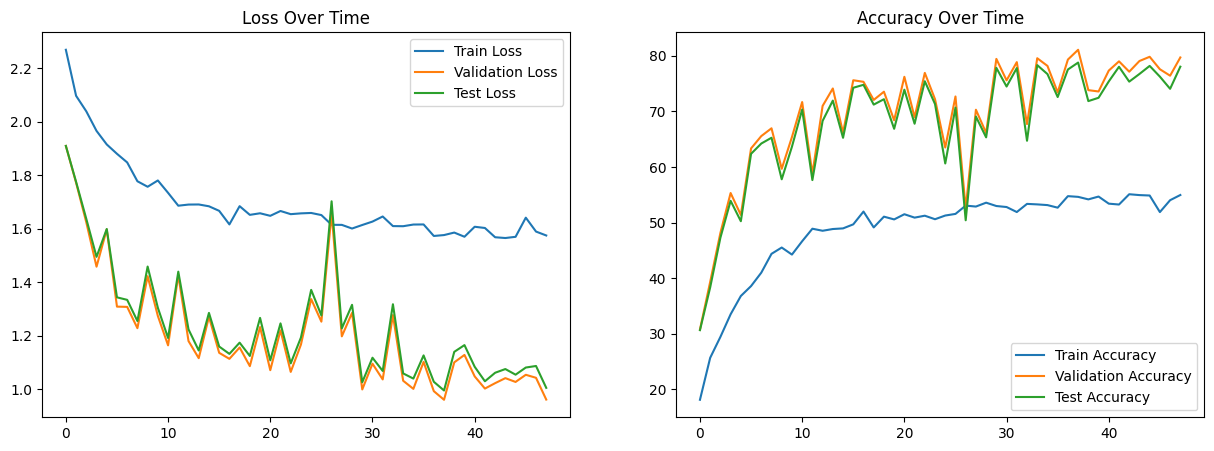

In [5]:
# Plot Training Progress
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy Over Time')
plt.legend()
plt.show()

In [6]:
# Load the best model for evaluation
print("Loading best model for final evaluation...")
net = ResNet18().to(device)
net.load_state_dict(torch.load(best_model_path))
if device == 'cuda':
    net = torch.nn.DataParallel(net)
net.eval()

# Final evaluation
_, final_test_acc = test(num_epochs)
print(f"Final Test Accuracy: {final_test_acc:.3f}%")

Loading best model for final evaluation...
Test Epoch 100: Loss: 0.996 | Acc: 78.780%
Final Test Accuracy: 78.780%


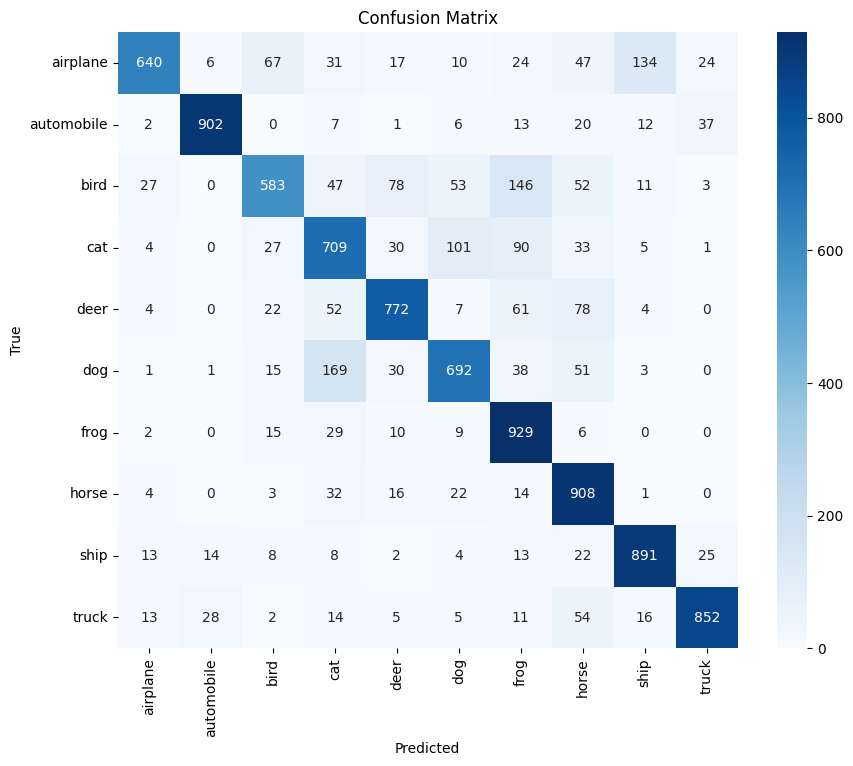

Classification Report:
              precision    recall  f1-score   support

    airplane       0.90      0.64      0.75      1000
  automobile       0.95      0.90      0.92      1000
        bird       0.79      0.58      0.67      1000
         cat       0.65      0.71      0.68      1000
        deer       0.80      0.77      0.79      1000
         dog       0.76      0.69      0.72      1000
        frog       0.69      0.93      0.79      1000
       horse       0.71      0.91      0.80      1000
        ship       0.83      0.89      0.86      1000
       truck       0.90      0.85      0.88      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



In [9]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

all_predictions = []
all_targets = []

with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# CIFAR-10 class labels
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Plot confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_targets, all_predictions, target_names=classes))

In [10]:
# For Kaggle submission - improved normalization consistency
def load_and_predict_kaggle_test(file_path):
    import pickle
    
    # Load the batch
    with open(file_path, "rb") as fo:
        batch = pickle.load(fo, encoding="bytes")
    
    # Extract images 
    test_images = batch[b"data"]
    
    # Check if reshaping is needed
    if len(test_images.shape) == 2:  # If images are flattened (CIFAR format)
        test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    
    # Convert to pytorch tensors with correct normalization
    test_dataset = []
    for img in test_images:
        # Convert to tensor and normalize consistently with our pipeline
        tensor_img = transforms.ToTensor()(img)
        normalized_img = transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                             (0.2023, 0.1994, 0.2010))(tensor_img)
        test_dataset.append(normalized_img)
    
    test_dataset = torch.stack(test_dataset)
    
    # Move to device and predict
    test_dataset = test_dataset.to(device)
    
    # Run inference in batches to avoid memory issues
    batch_size = 100
    predictions = []
    
    with torch.no_grad():
        for i in range(0, len(test_dataset), batch_size):
            batch = test_dataset[i:i+batch_size]
            outputs = net(batch)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())
    
    return predictions, test_images

# Generate Kaggle submission
predictions, test_images = load_and_predict_kaggle_test("cifar_test_nolabel.pkl")

In [11]:
# Create submission file
import pandas as pd
submission_df = pd.DataFrame({
    "ID": np.arange(len(predictions)), 
    "Label": [classes[p] for p in predictions]
})
submission_df.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")


Submission file saved as submission.csv


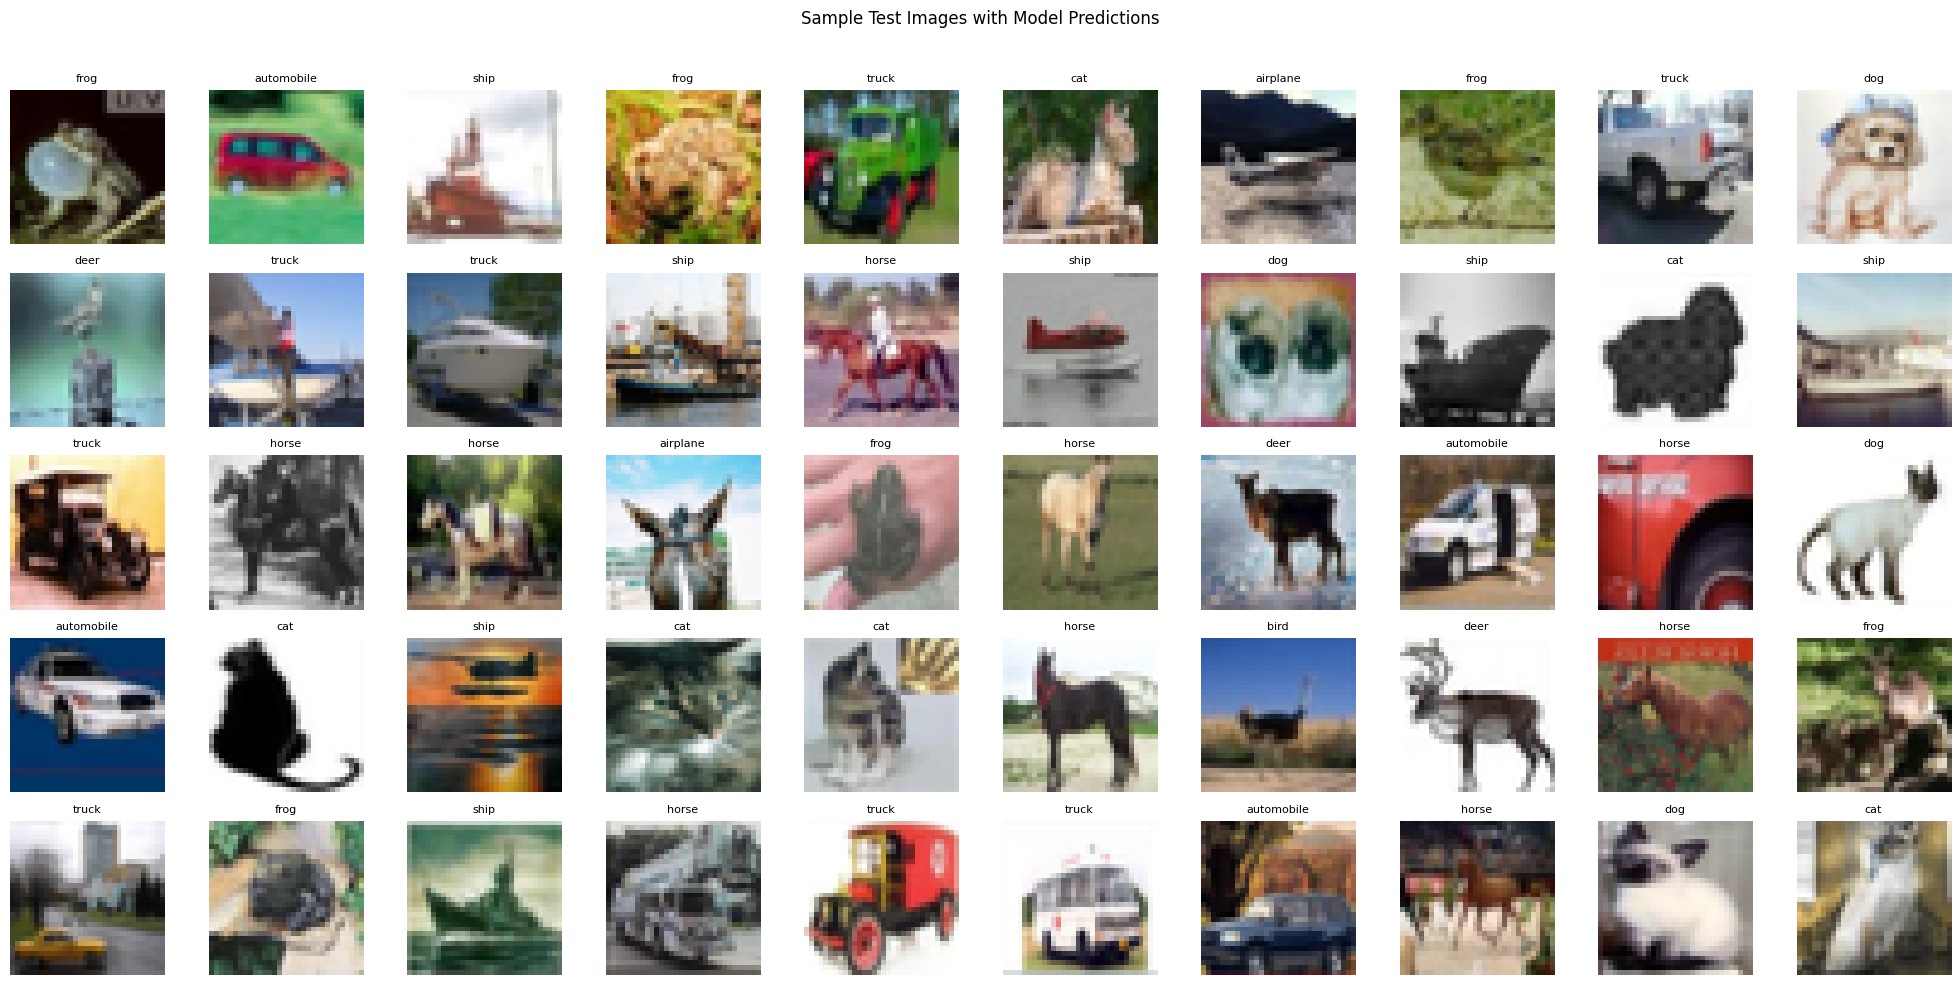

In [12]:
# Display sample predictions
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = axes.ravel()

for i in range(min(50, len(test_images))):
    axes[i].imshow(test_images[i])
    axes[i].axis("off")
    axes[i].set_title(f"{classes[predictions[i]]}", fontsize=8)

plt.suptitle("Sample Test Images with Model Predictions")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
